In [1]:
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.11.5 pynndescent==0.5.12


In [2]:
nr = sc.read_h5ad('./NR/NR_l6ct_filter.h5ad')
dr = sc.read_h5ad('./DR/DR_l6ct_filter.h5ad')

In [3]:
nr_ptime = pd.read_csv('./ptime/N_V2L_L6ct_V_pseudotime.txt',sep='\t')
dr_ptime = pd.read_csv('./ptime/D_V2L_L6ct_V_pseudotime.txt',sep='\t')

In [4]:
import seaborn as sns
sns.set_theme(style="ticks")

In [5]:
nr_exp=pd.DataFrame(nr.X.todense(),index=nr.obs.index,columns=nr.var.index)
nr_exp = nr_exp.reset_index()
nr_exp['cell_id_match'] = nr_exp['index'].str[:12]
df_ptime_nr = pd.merge(nr_exp, nr_ptime, left_on='cell_id_match', right_on='cell_id', how='left')

df_ptime_nr = df_ptime_nr.drop(columns=['cell_id_match', 'cell_id']).set_index('index')
df_ptime_nr = df_ptime_nr.dropna()
df_ptime_nr_sorted = df_ptime_nr.sort_values(by='velocity_pseudotime', ascending=True)


dr_exp=pd.DataFrame(dr.X.todense(),index=dr.obs.index,columns=dr.var.index)
dr_exp = dr_exp.reset_index()
dr_exp['cell_id_match'] = dr_exp['index'].str[:12]
df_ptime_dr = pd.merge(dr_exp, dr_ptime, left_on='cell_id_match', right_on='cell_id', how='left')

df_ptime_dr = df_ptime_dr.drop(columns=['cell_id_match', 'cell_id']).set_index('index')
df_ptime_dr = df_ptime_dr.dropna()
df_ptime_dr_sorted = df_ptime_dr.sort_values(by='velocity_pseudotime', ascending=True)

df_ptime_nr_sorted = df_ptime_nr.sort_values(by='velocity_pseudotime', ascending=True)
df_ptime_dr_sorted = df_ptime_dr.sort_values(by='velocity_pseudotime', ascending=True)
df_ptime_nr_sorted['index'] = range(df_ptime_nr_sorted.shape[0])
df_ptime_nr_sorted['index_bin'] = pd.cut(df_ptime_nr_sorted['index'], bins=np.arange(0, 1872 + 1872/50, 1872/50))
bin_means_nr = df_ptime_nr_sorted.groupby('index_bin').mean()
df_ptime_dr_sorted['index'] = range(df_ptime_dr_sorted.shape[0])
df_ptime_dr_sorted['index_bin'] = pd.cut(df_ptime_dr_sorted['index'], bins=np.arange(0, 1652 + 1652/50, 1652/50))
bin_means_dr = df_ptime_dr_sorted.groupby('index_bin').mean()
bin_means_nr['index'] = range(bin_means_nr.shape[0])
bin_means_dr['index'] = range(bin_means_dr.shape[0])

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/3137590657.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means_nr = df_ptime_nr_sorted.groupby('index_bin').mean()
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/3137590657.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means_dr = df_ptime_dr_sorted.groupby('index_bin').mean()


In [6]:
pc_gene = pd.read_csv('V2L_L6CT_Lasso_PC1rank.xls',sep='\t')

In [7]:
nr_pc_gene = pc_gene[['Gene','nr_pc_lasso','logFC']]
dr_pc_gene = pc_gene[['Gene','dr_pc_lasso','logFC']]

In [8]:
bin_means_nr_ = bin_means_nr
bin_means_nr_.index = list(bin_means_nr_['index'])
del bin_means_nr_['index']
bin_means_nr_T = bin_means_nr_.T

bin_means_dr_ = bin_means_dr
bin_means_dr_.index = list(bin_means_dr_['index'])
del bin_means_dr_['index']
bin_means_dr_T = bin_means_dr_.T

slope_ =[]
for i in range(bin_means_dr_T.shape[0]):
    x = np.array(bin_means_dr.index)
    y = np.array(bin_means_dr[bin_means_dr_T.index[i]])
    valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x = x[valid_indices]
    y = y[valid_indices]
    slope,intercept = np.polyfit(x, y,1)
    slope_.append(slope)
bin_means_dr_T['slope'] = slope_

slope_ =[]
for i in range(bin_means_nr_T.shape[0]):
    x = np.array(bin_means_nr.index)
    y = np.array(bin_means_nr[bin_means_nr_T.index[i]])
    valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
    x = x[valid_indices]
    y = y[valid_indices]
    slope,intercept = np.polyfit(x, y,1)
    slope_.append(slope)
bin_means_nr_T['slope'] = slope_

In [9]:
nr_pc_gene = pc_gene[['Gene','nr_pc_lasso','logFC']]
dr_pc_gene = pc_gene[['Gene','dr_pc_lasso','logFC']]
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_dr_T.index)
slope_df['slope']= list(bin_means_dr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(dr_pc_gene.shape[0]):
    if dr_pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][dr_pc_gene['Gene'][i]])
    else:
        slope.append('No')
dr_pc_gene['slope'] = slope
dr_pc_gene = dr_pc_gene[dr_pc_gene['slope'] != 'No']
dr_pc_gene['slope_abs'] = dr_pc_gene['slope'].abs()

dr_pc_gene_filter = dr_pc_gene[dr_pc_gene['dr_pc_lasso'] != 4000]
###
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_nr_T.index)
slope_df['slope']= list(bin_means_nr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(nr_pc_gene.shape[0]):
    if nr_pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][nr_pc_gene['Gene'][i]])
    else:
        slope.append('No')
nr_pc_gene['slope'] = slope
nr_pc_gene = nr_pc_gene[nr_pc_gene['slope'] != 'No']
nr_pc_gene['slope_abs'] = nr_pc_gene['slope'].abs()

nr_pc_gene_filter = nr_pc_gene[nr_pc_gene['nr_pc_lasso'] != 4000]

nr_pc_gene_filter['Cond'] = 'NR'
dr_pc_gene_filter['Cond'] = 'DR'

nr_pc_gene_filter['Rank'] = nr_pc_gene_filter['nr_pc_lasso']
dr_pc_gene_filter['Rank'] = dr_pc_gene_filter['dr_pc_lasso']
del nr_pc_gene_filter['nr_pc_lasso']
del dr_pc_gene_filter['dr_pc_lasso']
df_merge_pc_gene = pd.concat([nr_pc_gene_filter, dr_pc_gene_filter])

df_merge_pc_gene['slope_abs'] = df_merge_pc_gene['slope_abs']*50

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/586056469.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_pc_gene['slope'] = slope
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/586056469.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nr_pc_gene['slope'] = slope
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/586056469.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [10]:
df_NR = df_merge_pc_gene[df_merge_pc_gene['Cond'] == 'NR']
df_DR = df_merge_pc_gene[df_merge_pc_gene['Cond'] == 'DR']

In [11]:
df_NR_0 = df_NR[df_NR['slope_abs'] > 1]
df_NR_1 = df_NR[(df_NR['slope_abs'] > 0.5) & (df_NR['slope_abs'] <= 1) ]
df_NR_2 = df_NR[(df_NR['slope_abs'] > 0.1) & (df_NR['slope_abs'] <= 0.5) ]
df_NR_3 = df_NR[(df_NR['slope_abs'] > 0.02) & (df_NR['slope_abs'] <= 0.1) ]
df_NR_4 = df_NR[df_NR['slope_abs'] <= 0.02]

df_DR_0 = df_DR[df_DR['slope_abs'] > 1]
df_DR_1 = df_DR[(df_DR['slope_abs'] > 0.5) & (df_DR['slope_abs'] <= 1) ]
df_DR_2 = df_DR[(df_DR['slope_abs'] > 0.1) & (df_DR['slope_abs'] <= 0.5) ]
df_DR_3 = df_DR[(df_DR['slope_abs'] > 0.02) & (df_DR['slope_abs'] <= 0.1) ]
df_DR_4 = df_DR[df_DR['slope_abs'] <= 0.02]

拟合参数：a = 32.70148875333171, b = -2.61427866164303


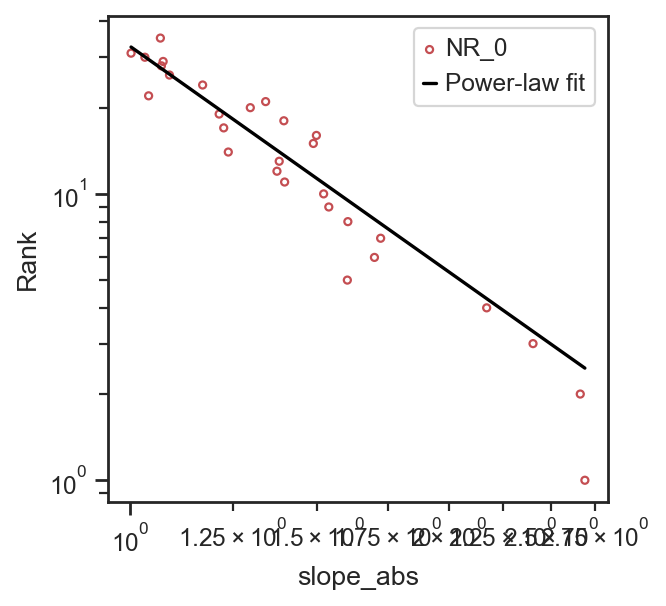

In [12]:
Rank = np.array(df_NR_0['Rank']+1)
slope_abs = np.array(df_NR_0['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)

params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='NR_0', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

拟合参数：a = 29.786219738804967, b = -1.4416594364279258


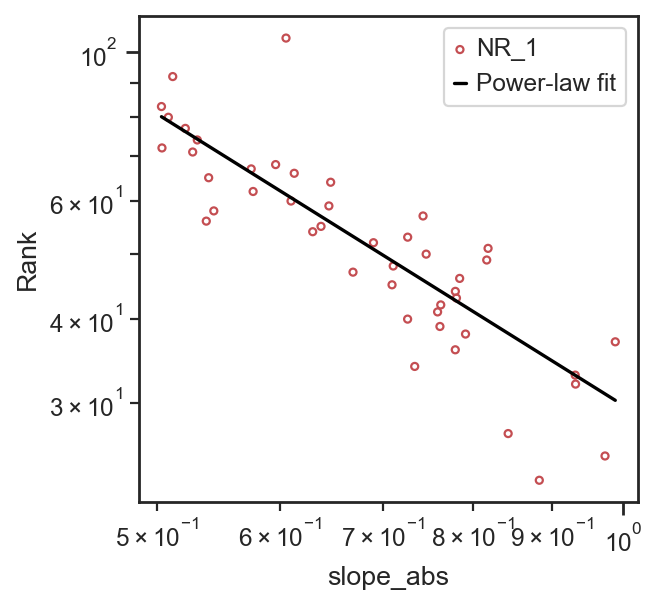

In [13]:
Rank = np.array(df_NR_1['Rank']+1)
slope_abs = np.array(df_NR_1['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)

params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

print(f"拟合参数：a = {a}, b = {b}")


plt.scatter(slope_abs, Rank, label='NR_1', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

拟合参数：a = 51.93092842020871, b = -0.953013123691686


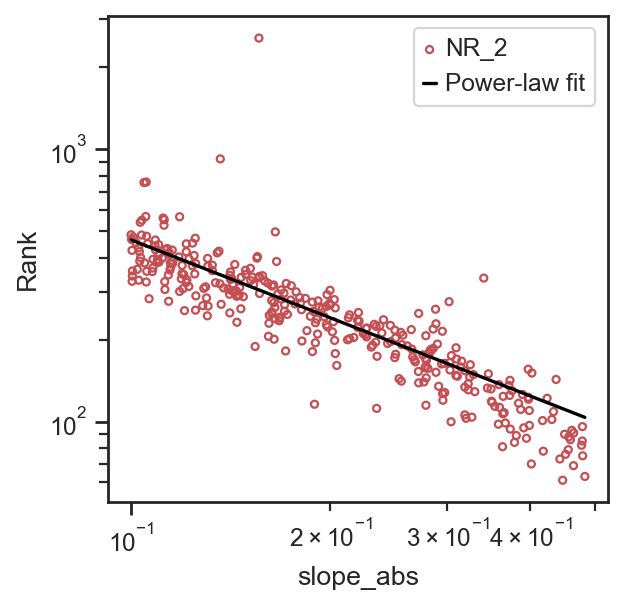

In [14]:
Rank = np.array(df_NR_2['Rank']+1)
slope_abs = np.array(df_NR_2['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)


params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params


print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='NR_2', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

拟合参数：a = 66.09094765639608, b = -0.817559946580673


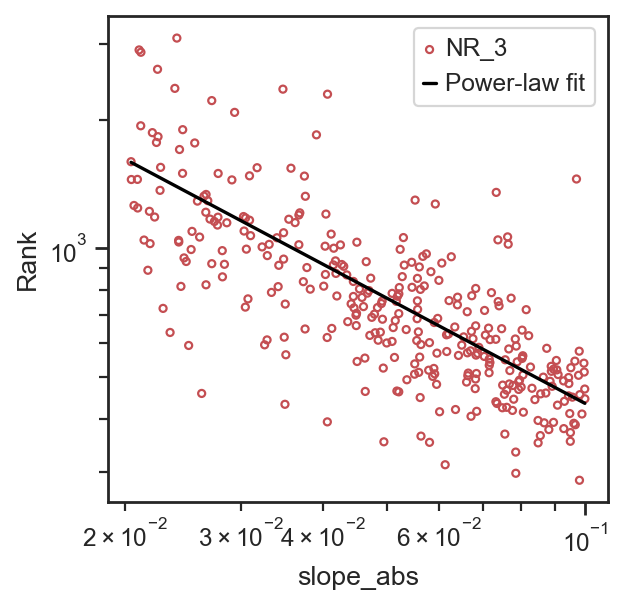

In [15]:
Rank = np.array(df_NR_3['Rank']+1)
slope_abs = np.array(df_NR_3['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)


params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params


print(f"拟合参数：a = {a}, b = {b}")


plt.scatter(slope_abs, Rank, label='NR_3', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

拟合参数：a = 1319.4740648995248, b = -0.09200033869600685


/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/3574044677.py:8: RuntimeWarning: overflow encountered in power
  return a * np.power(x, b)


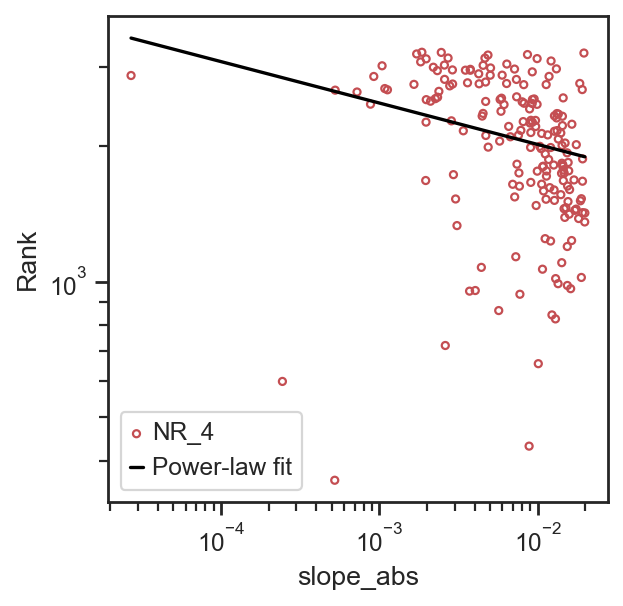

In [16]:
Rank = np.array(df_NR_4['Rank']+1)
slope_abs = np.array(df_NR_4['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)


params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params


print(f"拟合参数：a = {a}, b = {b}")


plt.scatter(slope_abs, Rank, label='NR_4', color='r', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log') 
plt.show()

In [17]:
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_nr_T.index)
slope_df['slope']= list(bin_means_nr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(pc_gene.shape[0]):
    if pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][pc_gene['Gene'][i]])
    else:
        slope.append('No')
pc_gene['NR_slope'] = slope
pc_gene['NR_slope'] = pd.to_numeric(pc_gene['NR_slope'], errors='coerce')
pc_gene['NR_slope_abs'] = (pc_gene['NR_slope']*50).abs()
###
slope_df = pd.DataFrame()
slope_df.index=list(bin_means_dr_T.index)
slope_df['slope']= list(bin_means_dr_T['slope'])
slope_dic = slope_df.to_dict()

slope = []
for i in range(pc_gene.shape[0]):
    if pc_gene['Gene'][i] in slope_df['slope'].keys():
        slope.append(slope_df['slope'][pc_gene['Gene'][i]])
    else:
        slope.append('No')
pc_gene['DR_slope'] = slope
pc_gene['DR_slope'] = pd.to_numeric(pc_gene['DR_slope'], errors='coerce')
pc_gene['DR_slope_abs'] = (pc_gene['DR_slope']*50).abs()

拟合参数：a = 22.03942393088886, b = -2.601760503688327


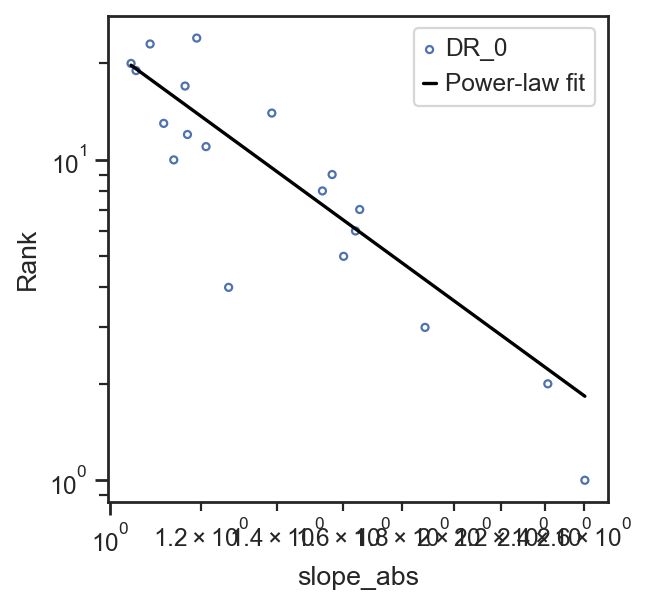

In [18]:
Rank = np.array(df_DR_0['Rank']+1)
slope_abs = np.array(df_DR_0['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)


params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

print(f"拟合参数：a = {a}, b = {b}")


plt.scatter(slope_abs, Rank, label='DR_0', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

拟合参数：a = 19.524514103319273, b = -1.9259703121216394


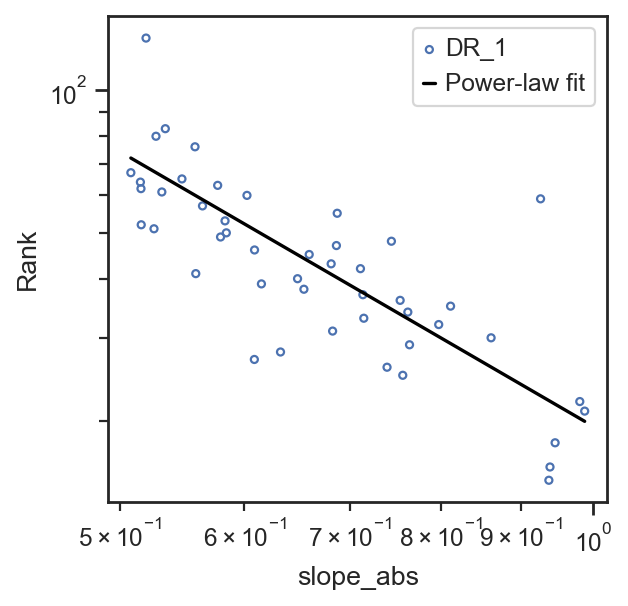

In [19]:
Rank = np.array(df_DR_1['Rank']+1)
slope_abs = np.array(df_DR_1['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)


params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

print(f"拟合参数：a = {a}, b = {b}")


plt.scatter(slope_abs, Rank, label='DR_1', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

拟合参数：a = 43.354569813876786, b = -1.0614399146463613


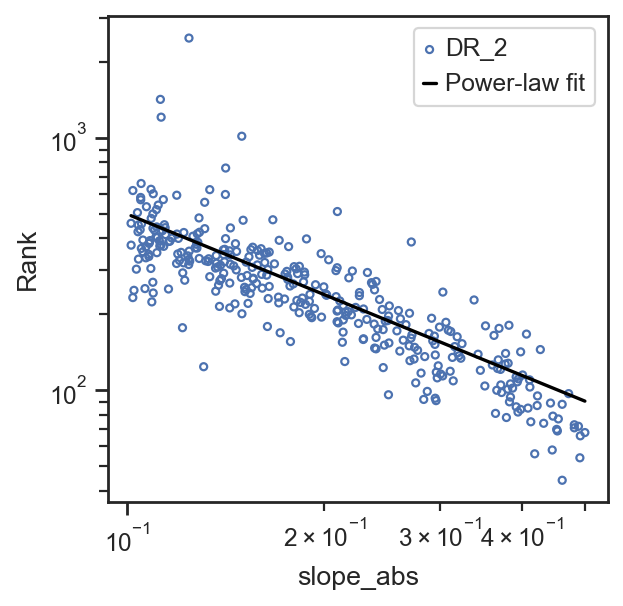

In [20]:
Rank = np.array(df_DR_2['Rank']+1)
slope_abs = np.array(df_DR_2['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)

params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='DR_2', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log') 
plt.show()

拟合参数：a = 83.52017527117331, b = -0.75409232342345


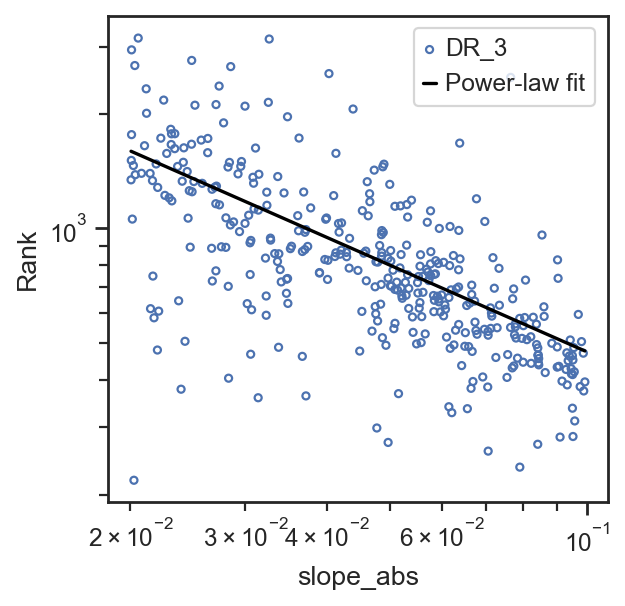

In [21]:
Rank = np.array(df_DR_3['Rank']+1)
slope_abs = np.array(df_DR_3['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)


params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

print(f"拟合参数：a = {a}, b = {b}")


plt.scatter(slope_abs, Rank, label='DR_3', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log') 
plt.show()

拟合参数：a = 1389.891028559905, b = -0.07842204015350727


/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/1950107419.py:8: RuntimeWarning: overflow encountered in power
  return a * np.power(x, b)


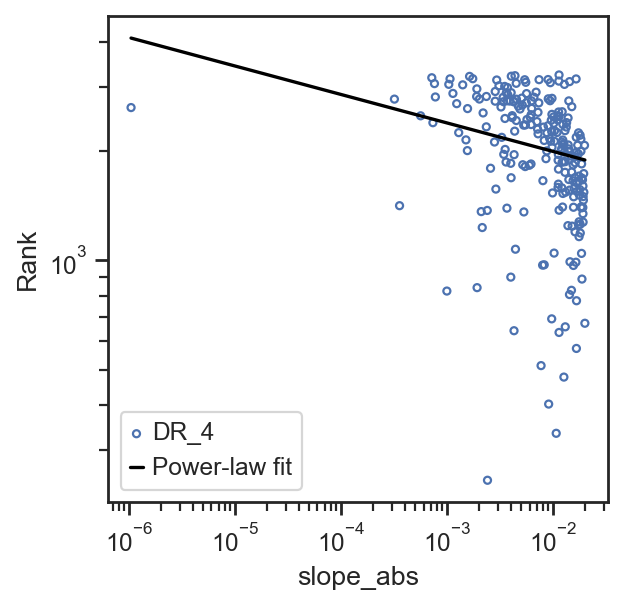

In [22]:
Rank = np.array(df_DR_4['Rank']+1)
slope_abs = np.array(df_DR_4['slope_abs'])
from scipy.optimize import curve_fit


def power_law(x, a, b):
    return a * np.power(x, b)

params, covariance = curve_fit(power_law, slope_abs, Rank)
a, b = params

print(f"拟合参数：a = {a}, b = {b}")

plt.scatter(slope_abs, Rank, label='DR_4', color='b', s=10, facecolor='none')
x_fit = np.linspace(min(slope_abs), max(slope_abs), 100)
y_fit = power_law(x_fit, a, b)
plt.plot(x_fit, y_fit, 'black', label='Power-law fit')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.show()

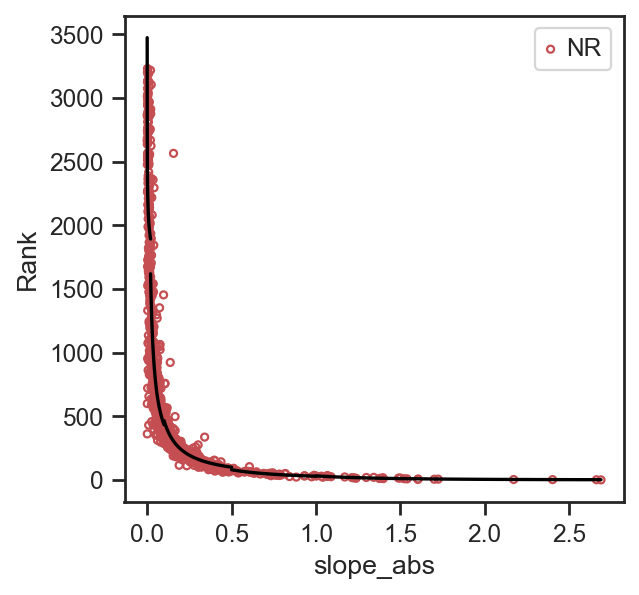

In [23]:
Rank = np.array(df_NR['Rank']+1)
slope_abs = np.array(df_NR['slope_abs'])


nr_0_a = 32.7014
nr_0_b = -2.6142
nr_1_a = 29.7862
nr_1_b = -1.44165
nr_2_a = 51.9309
nr_2_b = -0.953013
nr_3_a = 66.09094
nr_3_b = -0.81755
nr_4_a = 1319.47406
nr_4_b = -0.0920

plt.scatter(slope_abs, Rank, label='NR', color='r', s=10, facecolor='none')
nr_x_fit_0 = np.linspace(1, max(slope_abs), 100)
nr_y_fit_0 = power_law(nr_x_fit_0, nr_0_a, nr_0_b)
nr_x_fit_1 = np.linspace(0.5, 1, 100)
nr_y_fit_1 = power_law(nr_x_fit_1, nr_1_a, nr_1_b)
nr_x_fit_2 = np.linspace(0.1, 0.5, 100)
nr_y_fit_2 = power_law(nr_x_fit_2, nr_2_a, nr_2_b)
nr_x_fit_3 = np.linspace(0.02, 0.1, 100)
nr_y_fit_3 = power_law(nr_x_fit_3, nr_3_a, nr_3_b)
nr_x_fit_4 = np.linspace(min(slope_abs), 0.02, 100)
nr_y_fit_4 = power_law(nr_x_fit_4, nr_4_a, nr_4_b)
plt.plot(nr_x_fit_0, nr_y_fit_0, 'black')
plt.plot(nr_x_fit_1, nr_y_fit_1, 'black')
plt.plot(nr_x_fit_2, nr_y_fit_2, 'black')
plt.plot(nr_x_fit_3, nr_y_fit_3, 'black')
plt.plot(nr_x_fit_4, nr_y_fit_4, 'black')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()


plt.show()

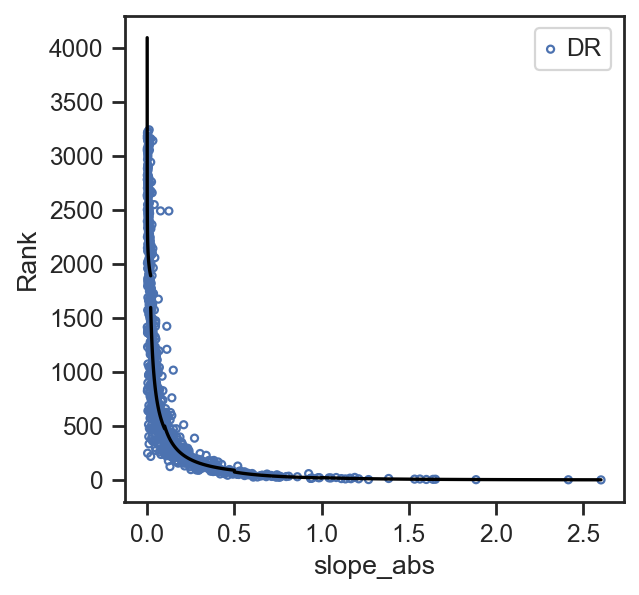

In [24]:
Rank = np.array(df_DR['Rank']+1)
slope_abs = np.array(df_DR['slope_abs'])

'''
a = 22.03942393088886, b = -2.601760503688327
a = 19.524514103319273, b = -1.9259703121216394
a = 43.354569813876786, b = -1.0614399146463613
a = 83.52017527117331, b = -0.75409232342345
a = 1389.891028559905, b = -0.07842204015350727
'''
nr_0_a = 22.0394
nr_0_b = -2.6017
nr_1_a = 19.5245
nr_1_b = -1.9259
nr_2_a = 43.3545
nr_2_b = -1.0614
nr_3_a = 83.5201
nr_3_b = -0.75409
nr_4_a = 1389.8910
nr_4_b = -0.0784

# 绘制原始数据和拟合曲线
plt.scatter(slope_abs, Rank, label='DR', color='b', s=10, facecolor='none')
nr_x_fit_0 = np.linspace(1, max(slope_abs), 100)
nr_y_fit_0 = power_law(nr_x_fit_0, nr_0_a, nr_0_b)
nr_x_fit_1 = np.linspace(0.5, 1, 100)
nr_y_fit_1 = power_law(nr_x_fit_1, nr_1_a, nr_1_b)
nr_x_fit_2 = np.linspace(0.1, 0.5, 100)
nr_y_fit_2 = power_law(nr_x_fit_2, nr_2_a, nr_2_b)
nr_x_fit_3 = np.linspace(0.02, 0.1, 100)
nr_y_fit_3 = power_law(nr_x_fit_3, nr_3_a, nr_3_b)
nr_x_fit_4 = np.linspace(min(slope_abs), 0.02, 100)
nr_y_fit_4 = power_law(nr_x_fit_4, nr_4_a, nr_4_b)
plt.plot(nr_x_fit_0, nr_y_fit_0, 'black')
plt.plot(nr_x_fit_1, nr_y_fit_1, 'black')
plt.plot(nr_x_fit_2, nr_y_fit_2, 'black')
plt.plot(nr_x_fit_3, nr_y_fit_3, 'black')
plt.plot(nr_x_fit_4, nr_y_fit_4, 'black')
plt.xlabel('slope_abs')
plt.ylabel('Rank')
plt.legend()

plt.show()

In [25]:
NR_predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['NR_slope_abs'][i] >1:
        rank = 32.7014* np.power(pc_gene['NR_slope_abs'][i], -2.6142)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slope_abs'][i] >0.5:
        rank = 29.7862* np.power(pc_gene['NR_slope_abs'][i], -1.4416)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slope_abs'][i] >0.1:
        rank = 51.9309* np.power(pc_gene['NR_slope_abs'][i],-0.953)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slope_abs'][i] > 0.02:
        rank = 66.0909* np.power(pc_gene['NR_slope_abs'][i],-0.8175)
        NR_predicted_rank.append(rank)
    elif pc_gene['NR_slope_abs'][i] <= 0.02:
        rank = 1319.4740* np.power(pc_gene['NR_slope_abs'][i],-0.092)
        NR_predicted_rank.append(rank)
    else:
        NR_predicted_rank.append('no')
pc_gene['NR_predicted_rank'] = NR_predicted_rank

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/1184495106.py:16: RuntimeWarning: divide by zero encountered in power
  rank = 1319.4740* np.power(pc_gene['NR_slope_abs'][i],-0.092)


In [27]:
'''
##DR
a = 22.03942393088886, b = -2.601760503688327
a = 19.524514103319273, b = -1.9259703121216394
a = 43.354569813876786, b = -1.0614399146463613
a = 83.52017527117331, b = -0.75409232342345
a = 1389.891028559905, b = -0.07842204015350727
'''
DR_predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['DR_slope_abs'][i] >1:
        rank = 22.0394* np.power(pc_gene['DR_slope_abs'][i], -2.6017)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slope_abs'][i] >0.5:
        rank = 19.5245* np.power(pc_gene['DR_slope_abs'][i], -1.9259)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slope_abs'][i] >0.1:
        rank = 43.3545* np.power(pc_gene['DR_slope_abs'][i],-1.0614)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slope_abs'][i] > 0.02:
        rank = 83.5201* np.power(pc_gene['DR_slope_abs'][i],-0.75409)
        DR_predicted_rank.append(rank)
    elif pc_gene['DR_slope_abs'][i] <= 0.02:
        rank = 1389.891* np.power(pc_gene['DR_slope_abs'][i],-0.0784)
        DR_predicted_rank.append(rank)
pc_gene['DR_predicted_rank'] = DR_predicted_rank

In [28]:
pc_gene

,Unnamed: 0,Gene,nr_pc_lasso,dr_pc_lasso,foldchange,logFC,NR_slope,NR_slope_abs,DR_slope,DR_slope_abs,NR_predicted_rank,DR_predicted_rank
0,0,Gm13791,1448,4000,2.761215,1.015671,-0.000409,0.020469,-0.000647,0.032341,1587.887964,1110.644016
1,1,Zdhhc14,147,4000,27.033784,3.297087,0.006180,0.309016,0.005263,0.263132,159.027992,178.838605
2,2,Col8a1,4000,471,0.117971,-2.137321,-0.001694,0.084724,-0.003007,0.150344,497.162292,323.947270
3,3,Dctpp1,4000,2326,0.581605,-0.541964,0.000102,0.005108,0.000162,0.008115,2144.066192,2027.172185
4,4,Fa2h,4000,3181,0.795301,-0.229034,-0.000128,0.006408,-0.000014,0.000718,2099.823767,2451.683708
...,...,...,...,...,...,...,...,...,...,...,...,...
1372,1372,Mdh1,411,4000,9.711165,2.273276,0.002206,0.110300,0.000041,0.002036,424.476045,2259.318693
1373,1373,Zmiz1os1,4000,440,0.110222,-2.205255,-0.001861,0.093067,-0.002286,0.114322,460.417209,433.248481
1374,1374,Fam129b,527,4000,7.577652,2.025203,0.001653,0.082670,0.001004,0.050212,507.234160,797.070581
1375,1375,Tns1,394,4000,10.129114,2.315414,0.002161,0.108052,0.001681,0.084030,432.884807,540.587513


In [29]:
predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['nr_pc_lasso'][i] != 4000:
        predicted_rank.append(pc_gene['nr_pc_lasso'][i])
    else:
        predicted_rank.append(pc_gene['NR_predicted_rank'][i])
pc_gene['NR_predicted_rank_final'] = predicted_rank

predicted_rank = []
for i in range(pc_gene.shape[0]):
    if pc_gene['dr_pc_lasso'][i] != 4000:
        predicted_rank.append(pc_gene['dr_pc_lasso'][i])
    else:
        predicted_rank.append(pc_gene['DR_predicted_rank'][i])
pc_gene['DR_predicted_rank_final'] = predicted_rank

/opt/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


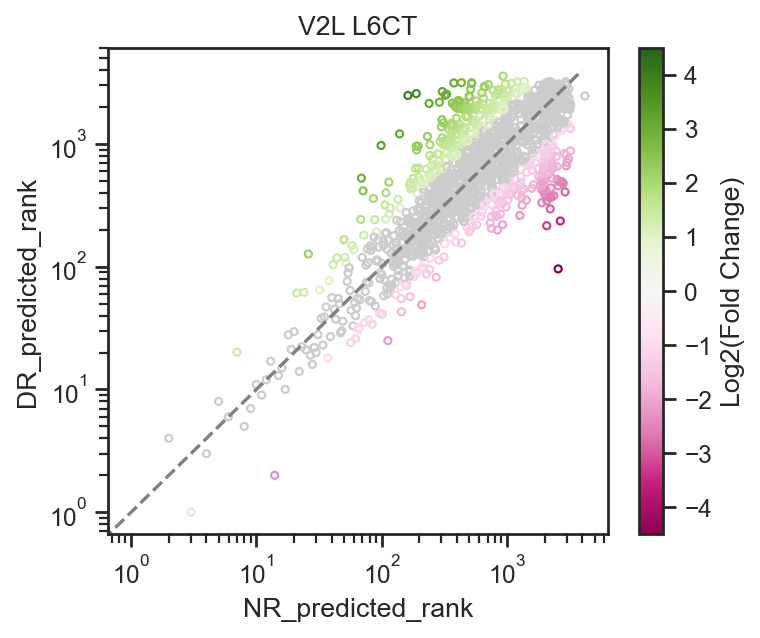

In [30]:
pc_gene['foldchange_predicted'] = (pc_gene['DR_predicted_rank_final']+1)/(pc_gene['NR_predicted_rank_final']+1)
pc_gene['logFC_predicted'] = np.log2(pc_gene['foldchange_predicted'])

color_condition = (pc_gene['logFC_predicted'] > -1) & (pc_gene['logFC_predicted'] < 1)

vmin, vmax = -4.5, 4.5

norm = plt.Normalize(vmin=vmin, vmax=vmax)


colors = plt.cm.PiYG(norm(pc_gene['logFC_predicted']))


#colors[gray_condition] = [0.5, 0.5, 0.5, 1.0]  # 灰色 (RGBA)
colors[color_condition] = [0.8, 0.8, 0.8, 1.0]  # 浅灰色 (RGBA)

fig, ax = plt.subplots(figsize=(5,4))

scatter = ax.scatter(x=pc_gene['NR_predicted_rank_final'], y=pc_gene['DR_predicted_rank_final'], 
                     s=10,marker='o', edgecolor=colors, facecolor='none')

sm = plt.cm.ScalarMappable(cmap="PiYG", norm=norm)
sm.set_array(pc_gene.loc[~color_condition, 'logFC_predicted'])  # 仅使用非灰色数据
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Log2(Fold Change)')

limits = [0, 4000, 4000]
ax.plot(limits, limits, linestyle='--', color='gray')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('NR_predicted_rank')
ax.set_ylabel('DR_predicted_rank')
ax.set_title('V2L L6CT')
plt.show()

In [31]:
subclass_deg = pd.read_csv('V2L_L6CT_subclass_DEG.xls',sep='\t')

In [32]:
subclass_deg

,Unnamed: 0,gene,log2FoldChange,pvalue,FDR,-log10(FDR),pts_u,pts_d,significance
0,0,Dpp10,0.321493,4.002174e-82,2.816730e-78,77.550255,1.000000,1.000000,Not Significant
1,1,AC149090.1,1.101161,5.515582e-53,2.911400e-49,48.535898,0.745157,0.509615,UP
2,2,Grm7,0.730612,1.057593e-51,4.466004e-48,47.350081,0.959443,0.863782,Not Significant
3,3,Shisa9,1.084806,5.730386e-50,2.016523e-46,45.695397,0.693099,0.423611,UP
4,4,Nkain2,0.483322,1.024345e-42,3.089718e-39,38.510081,0.994552,0.976496,Not Significant
...,...,...,...,...,...,...,...,...,...
21109,21109,Pitpnc1,-1.023326,4.527319e-27,2.275948e-24,23.642838,0.288136,0.407585,DOWN
21110,21110,Brinp3,-1.092924,4.744387e-28,2.862086e-25,24.543317,0.292373,0.414530,DOWN
21111,21111,Maml3,-1.095602,6.879667e-40,1.613970e-36,35.792105,0.400726,0.555021,DOWN
21112,21112,Gm42418,-0.717820,2.535950e-107,2.677202e-103,102.572319,0.981840,0.986645,Not Significant


In [33]:
subclass_deg = subclass_deg[subclass_deg['pvalue'] < 0.05]

In [34]:
subclass_deg

,Unnamed: 0,gene,log2FoldChange,pvalue,FDR,-log10(FDR),pts_u,pts_d,significance
0,0,Dpp10,0.321493,4.002174e-82,2.816730e-78,77.550255,1.000000,1.000000,Not Significant
1,1,AC149090.1,1.101161,5.515582e-53,2.911400e-49,48.535898,0.745157,0.509615,UP
2,2,Grm7,0.730612,1.057593e-51,4.466004e-48,47.350081,0.959443,0.863782,Not Significant
3,3,Shisa9,1.084806,5.730386e-50,2.016523e-46,45.695397,0.693099,0.423611,UP
4,4,Nkain2,0.483322,1.024345e-42,3.089718e-39,38.510081,0.994552,0.976496,Not Significant
...,...,...,...,...,...,...,...,...,...
21109,21109,Pitpnc1,-1.023326,4.527319e-27,2.275948e-24,23.642838,0.288136,0.407585,DOWN
21110,21110,Brinp3,-1.092924,4.744387e-28,2.862086e-25,24.543317,0.292373,0.414530,DOWN
21111,21111,Maml3,-1.095602,6.879667e-40,1.613970e-36,35.792105,0.400726,0.555021,DOWN
21112,21112,Gm42418,-0.717820,2.535950e-107,2.677202e-103,102.572319,0.981840,0.986645,Not Significant


In [35]:
subclass_deg_df = pd.DataFrame()
subclass_deg_df.index = list(subclass_deg['gene'])
subclass_deg_df['logFC'] = list(subclass_deg['log2FoldChange'])
subclass_deg_dict = subclass_deg_df.to_dict()

deglogFC = []
for i in range(pc_gene.shape[0]):
    if pc_gene['Gene'][i] in subclass_deg_dict['logFC'].keys():
        deglogFC.append(subclass_deg_dict['logFC'][pc_gene['Gene'][i]])
    else:
        deglogFC.append(0)
pc_gene['subclassdeglogFC'] = deglogFC

In [36]:
# 1. 筛选 logFC > 1 或 logFC < -1 的基因
filtered_df = pc_gene[(pc_gene['logFC_predicted'] > 1) | (pc_gene['logFC_predicted'] < -1)]

In [37]:
filtered_df

,Unnamed: 0,Gene,nr_pc_lasso,dr_pc_lasso,foldchange,logFC,NR_slope,NR_slope_abs,DR_slope,DR_slope_abs,NR_predicted_rank,DR_predicted_rank,NR_predicted_rank_final,DR_predicted_rank_final,foldchange_predicted,logFC_predicted,subclassdeglogFC
8,8,Txndc15,4000,414,0.103724,-2.266021,0.000300,0.015017,0.001895,0.094760,1941.580424,493.751057,1941.580424,414.000000,0.213633,-2.226791,0.383579
11,11,Celf5,4000,854,0.213697,-1.543198,-0.000173,0.008642,-0.000838,0.041910,2042.839340,913.458319,2042.839340,854.000000,0.418330,-1.257285,0.000000
13,13,Mia2,504,4000,7.922772,2.069741,0.001956,0.097804,0.000017,0.000854,442.105351,2418.651003,504.000000,2418.651003,4.791388,2.260444,0.000000
14,14,Cd46,283,4000,14.088028,2.645325,-0.003667,0.183326,-0.001562,0.078124,261.561444,571.124440,283.000000,571.124440,2.014523,1.010438,0.434460
15,15,Hs3st2,2563,96,0.037832,-3.274613,-0.003120,0.156022,-0.009435,0.471759,305.013620,96.238217,2563.000000,96.000000,0.037832,-4.724268,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,1357,9630041A04Rik,517,4000,7.723938,2.044324,0.001538,0.076921,0.000578,0.028881,538.023146,1209.566847,517.000000,1209.566847,2.337002,1.224659,-0.463226
1362,1362,Dbp,4000,694,0.173707,-1.750388,-0.000044,0.002221,-0.001068,0.053397,2314.871739,760.957918,2314.871739,694.000000,0.300103,-1.736470,1.288594
1365,1365,Disp2,304,4000,13.118033,2.573988,-0.003371,0.168560,-0.000638,0.031892,283.354300,1122.415658,304.000000,1122.415658,3.683330,1.881011,0.252450
1369,1369,Xpa,1842,455,0.247423,-1.396657,-0.000782,0.039109,0.001567,0.078362,935.310747,569.814680,1842.000000,455.000000,0.247423,-2.014950,0.421402


In [38]:
filtered_df.index = range(0,429)

In [39]:
fp = []
for i in range(filtered_df.shape[0]):
    test_slope = filtered_df['NR_slope_abs'][i] - filtered_df['DR_slope_abs'][i]
    test_rank = filtered_df['DR_predicted_rank_final'][i] - filtered_df['NR_predicted_rank_final'][i]
    test_slope_raw = filtered_df['NR_slope'][i] * filtered_df['DR_slope'][i]
    a = test_slope*test_rank
    if test_slope_raw < 0:
        fp.append('No')
    elif (filtered_df['subclassdeglogFC'][i] >0.4 or filtered_df['subclassdeglogFC'][i] < - 0.4):
        fp.append('No')
    elif test_slope_raw >= 0:
        if a <0:
            if test_rank < 0:
                if filtered_df['subclassdeglogFC'][i] <= 0:
                    fp.append('Yes')
                else:
                    fp.append('No')
            if test_rank > 0:
                if filtered_df['subclassdeglogFC'][i] >= 0:
                    fp.append('Yes')
                else:
                    fp.append('No')
        else:
            fp.append('No')
filtered_df['false_positive'] = fp

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/3602884899.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['false_positive'] = fp


In [40]:
filtered_df.to_csv('V2L_L6CT_Lasso_PC1rank_predict_sig.xls',sep='\t')

In [41]:
filtered_df['false_positive'].value_counts()

false_positive
No    429
Name: count, dtype: int64

In [44]:
filtered_df

,Unnamed: 0,Gene,nr_pc_lasso,dr_pc_lasso,foldchange,logFC,NR_slope,NR_slope_abs,DR_slope,DR_slope_abs,NR_predicted_rank,DR_predicted_rank,NR_predicted_rank_final,DR_predicted_rank_final,foldchange_predicted,logFC_predicted,subclassdeglogFC,false_positive,log Distance_to_Diagonal
0,8,Txndc15,4000,414,0.103724,-2.266021,0.000300,0.015017,0.001895,0.094760,1941.580424,493.751057,1941.580424,414.000000,0.213633,-2.226791,0.383579,No,0.473996
1,11,Celf5,4000,854,0.213697,-1.543198,-0.000173,0.008642,-0.000838,0.041910,2042.839340,913.458319,2042.839340,854.000000,0.418330,-1.257285,0.000000,No,0.267626
2,13,Mia2,504,4000,7.922772,2.069741,0.001956,0.097804,0.000017,0.000854,442.105351,2418.651003,504.000000,2418.651003,4.791388,2.260444,0.000000,No,0.481159
3,14,Cd46,283,4000,14.088028,2.645325,-0.003667,0.183326,-0.001562,0.078124,261.561444,571.124440,283.000000,571.124440,2.014523,1.010438,0.434460,No,0.215082
4,15,Hs3st2,2563,96,0.037832,-3.274613,-0.003120,0.156022,-0.009435,0.471759,305.013620,96.238217,2563.000000,96.000000,0.037832,-4.724268,0.000000,No,1.005609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,1357,9630041A04Rik,517,4000,7.723938,2.044324,0.001538,0.076921,0.000578,0.028881,538.023146,1209.566847,517.000000,1209.566847,2.337002,1.224659,-0.463226,No,0.260681
425,1362,Dbp,4000,694,0.173707,-1.750388,-0.000044,0.002221,-0.001068,0.053397,2314.871739,760.957918,2314.871739,694.000000,0.300103,-1.736470,1.288594,No,0.369626
426,1365,Disp2,304,4000,13.118033,2.573988,-0.003371,0.168560,-0.000638,0.031892,283.354300,1122.415658,304.000000,1122.415658,3.683330,1.881011,0.252450,No,0.400393
427,1369,Xpa,1842,455,0.247423,-1.396657,-0.000782,0.039109,0.001567,0.078362,935.310747,569.814680,1842.000000,455.000000,0.247423,-2.014950,0.421402,No,0.428903


In [ ]:
filtered_df

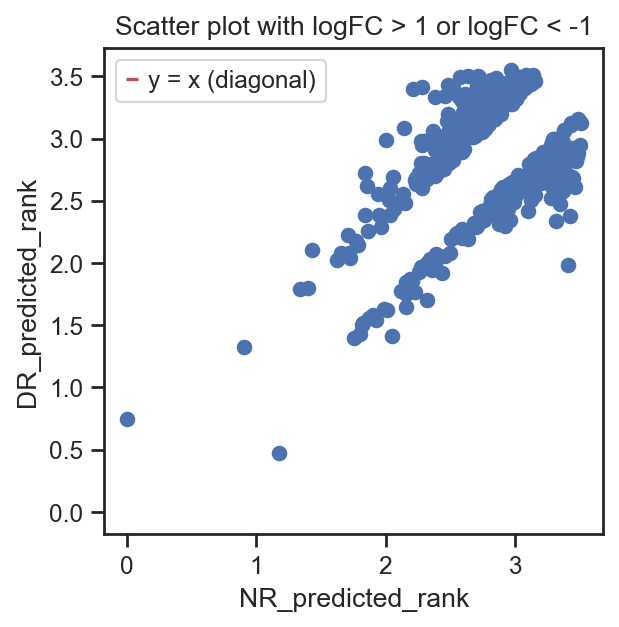

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/1312746351.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log Distance_to_Diagonal'] = log_distances


In [42]:
x = np.log10(filtered_df['NR_predicted_rank_final']+1)
y = np.log10(filtered_df['DR_predicted_rank_final']+1)

plt.scatter(x, y, color='b')
plt.plot([min(x), max(x)], [min(x), max(x)], 'r--', label='y = x (diagonal)')
plt.xlabel('NR_predicted_rank')
plt.ylabel('DR_predicted_rank')
plt.title('Scatter plot with logFC > 1 or logFC < -1')
plt.legend()
plt.show()

log_distances = np.abs(y - x) / np.sqrt(2)

filtered_df['log Distance_to_Diagonal'] = log_distances

In [43]:
variance_of_distances = np.var(log_distances)
variance_of_distances

nan

In [45]:
# 
inf_indices = np.isinf(log_distances)

log_distances[inf_indices] = np.nan

mean_value = np.mean(log_distances[~np.isnan(log_distances) & ~np.isinf(log_distances)])
log_distances[np.isnan(log_distances) | np.isinf(log_distances)] = mean_value


In [46]:
variance_of_distances = np.var(log_distances)
variance_of_distances

0.013591060715376913

In [47]:
filtered_df

,Unnamed: 0,Gene,nr_pc_lasso,dr_pc_lasso,foldchange,logFC,NR_slope,NR_slope_abs,DR_slope,DR_slope_abs,NR_predicted_rank,DR_predicted_rank,NR_predicted_rank_final,DR_predicted_rank_final,foldchange_predicted,logFC_predicted,subclassdeglogFC,false_positive,log Distance_to_Diagonal
0,8,Txndc15,4000,414,0.103724,-2.266021,0.000300,0.015017,0.001895,0.094760,1941.580424,493.751057,1941.580424,414.000000,0.213633,-2.226791,0.383579,No,0.473996
1,11,Celf5,4000,854,0.213697,-1.543198,-0.000173,0.008642,-0.000838,0.041910,2042.839340,913.458319,2042.839340,854.000000,0.418330,-1.257285,0.000000,No,0.267626
2,13,Mia2,504,4000,7.922772,2.069741,0.001956,0.097804,0.000017,0.000854,442.105351,2418.651003,504.000000,2418.651003,4.791388,2.260444,0.000000,No,0.481159
3,14,Cd46,283,4000,14.088028,2.645325,-0.003667,0.183326,-0.001562,0.078124,261.561444,571.124440,283.000000,571.124440,2.014523,1.010438,0.434460,No,0.215082
4,15,Hs3st2,2563,96,0.037832,-3.274613,-0.003120,0.156022,-0.009435,0.471759,305.013620,96.238217,2563.000000,96.000000,0.037832,-4.724268,0.000000,No,1.005609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,1357,9630041A04Rik,517,4000,7.723938,2.044324,0.001538,0.076921,0.000578,0.028881,538.023146,1209.566847,517.000000,1209.566847,2.337002,1.224659,-0.463226,No,0.260681
425,1362,Dbp,4000,694,0.173707,-1.750388,-0.000044,0.002221,-0.001068,0.053397,2314.871739,760.957918,2314.871739,694.000000,0.300103,-1.736470,1.288594,No,0.369626
426,1365,Disp2,304,4000,13.118033,2.573988,-0.003371,0.168560,-0.000638,0.031892,283.354300,1122.415658,304.000000,1122.415658,3.683330,1.881011,0.252450,No,0.400393
427,1369,Xpa,1842,455,0.247423,-1.396657,-0.000782,0.039109,0.001567,0.078362,935.310747,569.814680,1842.000000,455.000000,0.247423,-2.014950,0.421402,No,0.428903


In [48]:
pc_gene.to_csv('V2L_L6CT_Lasso_PC1rank.xls',sep='\t')

In [50]:
rcg_gene = list(filtered_df['Gene'])
rcg = []
for i in range(pc_gene.shape[0]):
    if pc_gene['Gene'][i] in rcg_gene:
        rcg.append('RCG')
    else:
        rcg.append('Non_RCG')
pc_gene['RCG'] = rcg

In [51]:
non_rcg = pc_gene[pc_gene['RCG'] == 'Non_RCG']
non_rcg_gene = list(non_rcg['Gene'])
RCG = []
for i in range(bin_means_nr_T.shape[0]):
    if bin_means_nr_T.index[i] in rcg_gene:
        RCG.append('RCG')
    elif bin_means_nr_T.index[i] in non_rcg_gene:
        RCG.append('Non_RCG')
    else:
        RCG.append('No')
bin_means_nr_T['RCG'] = RCG
nr_rcg = bin_means_nr_T[bin_means_nr_T['RCG'] == 'RCG']
nr_rcg_sorted = nr_rcg.sort_values(by='slope', ascending=True)
nr_non_rcg = bin_means_nr_T[bin_means_nr_T['RCG'] == 'Non_RCG']
nr_non_rcg_sorted = nr_non_rcg.sort_values(by='slope', ascending=True)

RCG = []
for i in range(bin_means_dr_T.shape[0]):
    if bin_means_dr_T.index[i] in rcg_gene:
        RCG.append('RCG')
    elif bin_means_dr_T.index[i] in non_rcg_gene:
        RCG.append('Non_RCG')
    else:
        RCG.append('No')
bin_means_dr_T['RCG'] = RCG
dr_rcg = bin_means_dr_T[bin_means_dr_T['RCG'] == 'RCG']
dr_non_rcg = bin_means_dr_T[bin_means_dr_T['RCG'] == 'Non_RCG']

rcg_df = pd.DataFrame()
rcg_df.index=list(nr_rcg_sorted.index)
rcg_df['RCG_order']= range(nr_rcg_sorted.shape[0])
rcg_dic = rcg_df.to_dict()

RCG_order = []
for i in range(dr_rcg.shape[0]):
    if dr_rcg.index[i] in rcg_dic['RCG_order'].keys():
        RCG_order.append(rcg_dic['RCG_order'][dr_rcg.index[i]])
dr_rcg['RCG_order'] = RCG_order
dr_rcg_sorted = dr_rcg.sort_values(by='RCG_order', ascending=True)

rcg_df = pd.DataFrame()
rcg_df.index=list(nr_non_rcg_sorted.index)
rcg_df['RCG_order']= range(nr_non_rcg_sorted.shape[0])
rcg_dic = rcg_df.to_dict()

RCG_order = []
for i in range(dr_non_rcg.shape[0]):
    if dr_non_rcg.index[i] in rcg_dic['RCG_order'].keys():
        RCG_order.append(rcg_dic['RCG_order'][dr_non_rcg.index[i]])
    else:
        RCG_order.append('No')
dr_non_rcg['RCG_order'] = RCG_order
dr_non_rcg = dr_non_rcg[dr_non_rcg['RCG_order'] != 'No']
dr_non_rcg_sorted = dr_non_rcg.sort_values(by='RCG_order', ascending=True)

/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/38468792.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_rcg['RCG_order'] = RCG_order
/var/folders/r4/hfj1yx3s3bd93mtgxzfwcfyc0000gn/T/ipykernel_9132/38468792.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_non_rcg['RCG_order'] = RCG_order


In [52]:
pc_gene['RCG'].value_counts()

RCG
Non_RCG    948
RCG        429
Name: count, dtype: int64

In [82]:
x = np.array(nr_dr_non_rcg_slope['NR_slope_sign'])
y = np.array(nr_dr_non_rcg_slope['DR_slope_sign'])
valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
x = x[valid_indices]
y = y[valid_indices]
spearman_coef, spearman_p = spearmanr(x, y)
print(f"Spearman corr: {spearman_coef}, p-value: {spearman_p}")

Spearman corr: 0.8401610889684805, p-value: 1.28223752007422e-253


In [83]:
x = np.array(nr_dr_rcg_slope['NR_slope_sign'])
y = np.array(nr_dr_rcg_slope['DR_slope_sign'])
valid_indices = ~(np.isnan(x) | np.isnan(y) | np.isinf(x) | np.isinf(y))
x = x[valid_indices]
y = y[valid_indices]
spearman_coef, spearman_p = spearmanr(x, y)
print(f"Spearman corr: {spearman_coef}, p-value: {spearman_p}")

Spearman corr: 0.6415645428251383, p-value: 4.000480266337425e-51


(-1.0, 1.0)

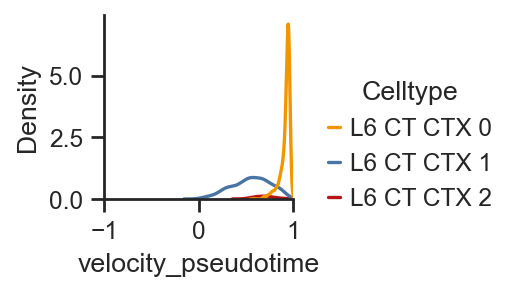

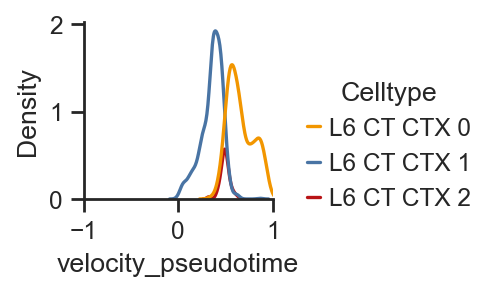

In [84]:
df_nr_ptime = pd.DataFrame( )
df_nr_ptime.index = nr.obs.index
df_nr_ptime['velocity_pseudotime'] = list(df_ptime_nr['velocity_pseudotime'])
df_nr_ptime['Celltype'] = nr.obs.Type
sns.displot(data=df_nr_ptime,x="velocity_pseudotime",hue="Celltype",kind="kde",palette=["#f29600","#4974a4","#b81316"],height=2,aspect=1)
plt.xlim(-1,1)
 
df_dr_ptime = pd.DataFrame( )
df_dr_ptime.index = dr.obs.index
df_dr_ptime['velocity_pseudotime'] = list(df_ptime_dr['velocity_pseudotime'])
df_dr_ptime['Celltype'] = dr.obs.Type
sns.displot(data=df_dr_ptime,x="velocity_pseudotime",hue="Celltype",kind="kde",palette=["#f29600","#4974a4","#b81316"],height=2,aspect=1)
plt.xlim(-1,1)